# Results and Issues
Covered in this notebook:
1. Obtain near-identical results to Ramirez's.
2. Highlight key issues impacting presented results.
    a. Problematic bet impacting results.
    b. Incorrect kelly criterion.

In [3]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import econtools.metrics as mt
import numpy as np
from econtools import read, outreg, table_statrow, write_notes
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('seaborn-v0_8-deep')

In [4]:
original_df = pd.read_csv(r'C:\Users\faxul\Google Drive\RamirezRepStudy\thesisminusdata\TradeCode\paper_repstudy\notFeelingTheBuzz\Datafiles\Ramirez_matches_cleaned.csv')
fitset = original_df[~(original_df['date'] > '2019-01-00')].copy()
testset = original_df[(original_df['date'] > '2019-01-00')].copy()

testset.reset_index(inplace=True)
print('Fit set rows: '+str(len(fitset)))
print('Test set rows: '+str(len(testset)))

Fit set rows: 15854
Test set rows: 5190


In [23]:
def fit_regression(rankdist: bool = True, wikibuzz: bool = True):
    if wikibuzz and rankdist:
        results = mt.reg(fitset,'outcome',                      
        ['inverse_avg', 'rankdist', 'wikibuzz'],
        #fe_name= "year",
        cluster='match_id',addcons=True)
        params = [results.beta[-1], results.beta[0], results.beta[1], results.beta[2]]
        #params= [constant        , inverse_avg    , rankdist       , wikibuzz       ]
    elif wikibuzz and not rankdist:
        results = mt.reg(fitset,'outcome',
        ['inverse_avg', 'wikibuzz'],
        #fe_name= "year",
        cluster='match_id',addcons=True)
        params = [results.beta[-1], results.beta[0], results.beta[1]]
        #params= [constant        , inverse_avg    , wikibuzz       ]
    elif rankdist and not wikibuzz:
        results = mt.reg(fitset,'outcome',
        ['inverse_avg', 'rankdist'],
        #fe_name= "year",
        cluster='match_id',addcons=True)
        params = [results.beta[-1], results.beta[0], results.beta[1]]
        #params= [constant        , inverse_avg    , rankdist       ]
    elif not rankdist and not wikibuzz:
        results = mt.reg(fitset,'outcome',                      
        ['inverse_avg'],
        #fe_name= "year",
        cluster='match_id',addcons=True)
        params = [results.beta[-1], results.beta[0]]
        #params= [constant        , inverse_avg    ]
    print(results)
    return params

def simple_probability(params: pd.Series,
                         inverse_odds: float):
    y_hat = params[0] + params[1]*inverse_odds
    return y_hat

def estimate_probability(params: pd.Series,
                         inverse_odds: float,
                         rankdist: float = None,
                         wikibuzz: float = None) -> float:
    if rankdist and wikibuzz:
        y_hat = params[0] + params[-3]*inverse_odds + params[-2]*rankdist + params[-1]*wikibuzz
    if wikibuzz and not rankdist:
        y_hat = params[0] + params[-2]*inverse_odds + params[-1]*wikibuzz
    if rankdist and not wikibuzz:
        y_hat = params[0] + params[-2] * inverse_odds + params[-1] * rankdist
    if not rankdist and not wikibuzz:
        y_hat = params[0] + params[1]*inverse_odds
    return y_hat

def kelly_criterion(odds_implied_prob, y_hat):
    odds = 1/odds_implied_prob
    k = max(y_hat - ((1 - y_hat)/(odds - 1)), 0)
    return k

def profit_loss(kelly, odds_implied_prob, outcome):
    odds = 1 / odds_implied_prob
    if outcome == 1:
        PnL = kelly*odds - kelly
    if outcome == 0:
        PnL = -kelly
    return PnL

def show_results(testset, params, odds, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"

    # Estimate Probability.
    if rankdist and wikibuzz:
        testset['model_est_prob'] = [estimate_probability(params, row[0], row[1], row[2]) for row in zip(testset['inverse_avg'],
                                                                                                         testset['rankdist'],
                                                                                                         testset['wikibuzz'])]
    elif wikibuzz and not rankdist:
        testset['model_est_prob'] = [estimate_probability(params, inverse_odds=row[0], wikibuzz=row[1]) for row in zip(testset['inverse_avg'],
                                                                                                                       testset['wikibuzz'])]
    elif rankdist and not wikibuzz:
        testset['model_est_prob'] = [estimate_probability(params, inverse_odds=row[0], rankdist=row[1]) for row in zip(testset['inverse_avg'],
                                                                                                                       testset['rankdist'])]
    elif not rankdist and not wikibuzz:
        testset['model_est_prob'] = [simple_probability(params, inverse_odds=x) for x in testset['inverse_avg']]          
    # Determine kelly bet size.
    testset['kelly_betsize'] = [kelly_criterion(row[0], row[1]) for row in zip(testset['inverse_{}'.format(odds)],
                                                                               testset['model_est_prob'])]
    # Calculate return for the bet.
    testset['PnL'] = [profit_loss(row[0], row[1], row[2]) for row in zip(testset['kelly_betsize'],testset['inverse_{}'.format(odds)],
                                                                         testset['outcome'])]

    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print('Absolute amount bet: '+str(testset['kelly_betsize'].sum()))
    print('Absolute return: '+str(testset['PnL'].sum()))
    print('ROI (%): '+str((((testset['PnL'].sum() + testset['kelly_betsize'].sum())/testset['kelly_betsize'].sum())-1)*100))

def plot_results():
    testset['Cum_PnL'] = testset['PnL'].cumsum() * 100
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    testset.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5)
    
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    
    ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey').set_linewidth(2.5)
    
    plt.show()
    
def correct_kelly_results(odds, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"
    
    params = fit_regression(rankdist=rankdist,wikibuzz=wikibuzz)
    show_results(testset, params, odds, rankdist=rankdist, wikibuzz=wikibuzz)
    
    testset['bankroll_after'] = testset['PnL'] + 1
    testset['bankroll_after'] = testset['bankroll_after'].cumprod()
    testset['bankroll_before'] = testset.bankroll_after.shift(1)
    testset['betsize_of_inital_bankroll'] = testset['kelly_betsize'] * testset['bankroll_before']
    testset['pnl_of_initial_bankroll'] = testset['PnL'] * testset['bankroll_before']
    print("---------------")
    print("*Correct Kelly*")
    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print('Absolute amount bet: ' + str(testset['betsize_of_inital_bankroll'].sum()))
    print('Absolute return: ' + str(testset['pnl_of_initial_bankroll'].sum()))
    print('ROI (%): ' + str((((testset['pnl_of_initial_bankroll'].sum() + testset['betsize_of_inital_bankroll'].sum()) / testset[
    'betsize_of_inital_bankroll'].sum()) - 1)*100))
    
    
def correct_kelly_plot_results():
    testset["Cum_PnL"] = (testset["bankroll_after"] -1) * 100
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    testset.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5)
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey').set_linewidth(2.5)
    
    plt.show()

## 1. Obtain near-identical results to Ramirez.

Dependent variable:	outcome
N:			15854
R-squared:		0.1589
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.025 0.028 36.945 0.000  0.971   1.080
rankdist     0.055 0.031  1.787 0.074 -0.005   0.115
wikibuzz     0.009 0.004  2.117 0.034  0.001   0.017
_cons       -0.041 0.015 -2.831 0.005 -0.070  -0.013

Bets considered (2 * Matches): 5156
Number of bets placed: 312
Mean overround (%): 6.456499124919013
Absolute amount bet: 7.151004389194103
Absolute return: 1.2360930817859561
ROI (%): 17.285586954104225


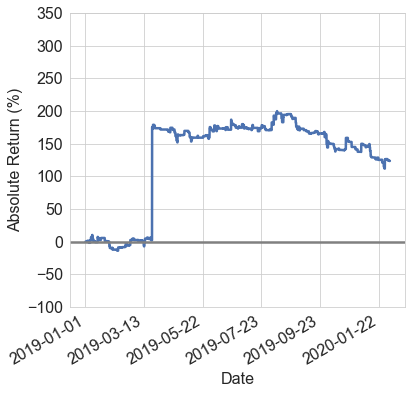

In [24]:
params = fit_regression(rankdist=True)
show_results(testset, params=params, odds="b365", rankdist=True)
plot_results()

In [33]:
testset = testset[testset['inverse_b365'] > testset['inverse_best']]

Dependent variable:	outcome
N:			15854
R-squared:		0.1586
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.005 0.025 39.826 0.000  0.956   1.055
wikibuzz     0.010 0.004  2.265 0.024  0.001   0.018
_cons       -0.031 0.013 -2.323 0.020 -0.057  -0.005

Bets considered (2 * Matches): 5156
Number of bets placed: 276
Mean overround (%): 6.456499124919013
Absolute amount bet: 4.987843280940591
Absolute return: 1.4372911056209992
ROI (%): 28.81588343228698


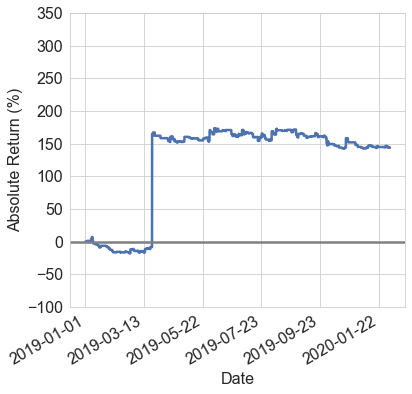

In [25]:
params = fit_regression(rankdist=False)
show_results(testset, params=params, odds="b365", rankdist=False)
plot_results()

Dependent variable:	outcome
N:			15854
R-squared:		0.1589
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.025 0.028 36.945 0.000  0.971   1.080
rankdist     0.055 0.031  1.787 0.074 -0.005   0.115
wikibuzz     0.009 0.004  2.117 0.034  0.001   0.017
_cons       -0.041 0.015 -2.831 0.005 -0.070  -0.013

Bets considered (2 * Matches): 5189
Number of bets placed: 2344
Mean overround (%): -0.22770090708685853
Absolute amount bet: 76.41329071216936
Absolute return: 2.4640318614272614
ROI (%): 3.2246116329536


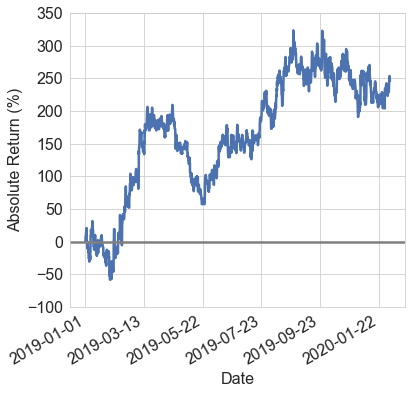

In [26]:
params = fit_regression(rankdist=True)
show_results(testset, params=params, odds="best", rankdist=True)
plot_results()

In [22]:
testset = testset[testset["match_id"] != 13918]

## 2.  Bet365 results skewed by profitable bet.

In [16]:
show_results(testset, params=params, odds="b365", rankdist=True)
testset.sort_values(by=["PnL"], ascending=False).head()

Bets considered (2 * Matches): 5156
Number of bets placed: 312
Mean overround (%): 6.456499124919013
Absolute return: 1.2360930817859561
Absolute amount bet: 7.151004389194103
ROI (%): 17.285586954104225


,index,Unnamed: 0,match_id,player,date,year,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome,model_est_prob,kelly_betsize,PnL,Cum_PnL,ROI,Cumulative_ROI
1135,16989,5883,5883,Polona Hercog,2019-03-23,2019.0,-0.001824,-1.707411,0.181818,0.540541,0.476190,1,0.497091,0.385334,1.734001,175.411390,1.018911,3.107266
4439,20293,20000,20000,Veronika Kudermetova,2019-10-17,2019.0,0.226190,1.707976,0.307692,0.364964,0.307692,1,0.360454,0.076212,0.171476,158.813457,0.254892,24390.964863
2482,18336,12033,12033,Yulia Putintseva,2019-06-20,2019.0,0.976744,1.032863,0.266667,0.279330,0.250000,1,0.307616,0.055840,0.153559,186.870823,0.533477,-30.196696
5104,20958,2540,2540,Sofia Kenin,2020-01-30,2020.0,0.933333,1.061726,0.266667,0.277778,0.248139,1,0.303912,0.050789,0.139668,125.830934,0.176759,-4260.229908
3209,19063,15953,15953,Sofia Kenin,2019-08-06,2019.0,0.965517,0.797335,0.230947,0.238663,0.217391,1,0.263184,0.041918,0.139587,193.082474,0.447508,22512.515222


In [6]:
# Remove bet...
testset.drop(index=1135, inplace=True)
# Then rerun all results above to see changes!

## 3. Correct kelly.
A Kelly criterion conventionally determines the bet size in respect to bankroll at the time of the bet, not the bankroll from the start of the test period.




Dependent variable:	outcome
N:			15854
R-squared:		0.1589
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.025 0.028 36.945 0.000  0.971   1.080
rankdist     0.055 0.031  1.787 0.074 -0.005   0.115
wikibuzz     0.009 0.004  2.117 0.034  0.001   0.017
_cons       -0.041 0.015 -2.831 0.005 -0.070  -0.013

Bets considered (2 * Matches): 5189
Number of bets placed: 2344
Mean overround (%): -0.22770090708685853
Absolute amount bet: 76.41329071216936
Absolute return: 2.4640318614272614
ROI (%): 3.2246116329536
---------------
*Correct Kelly*
Bets considered (2 * Matches): 5189
Number of bets placed: 2344
Mean overround (%): -0.22770090708685853
Absolute amount bet: 120.81961738693448
Absolute return: -0.16694619842431901
ROI (%): -0.1381780558778467


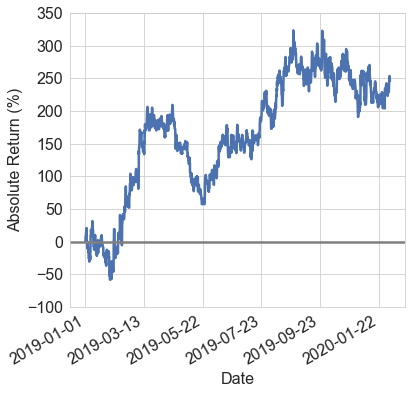

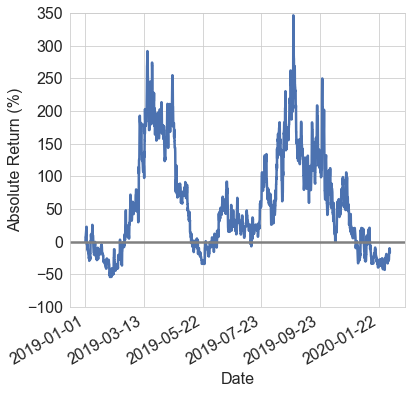

In [27]:
correct_kelly_results("best", rankdist=True)
plot_results()
correct_kelly_plot_results()

## 4. Best odds compared to simple strategy.
Below is the results from implementing no model at all and simply using the inverse average odds as the estimated probability and the best odds as the odds for returns.

In [30]:
correct_kelly_results("best", rankdist=True, wikibuzz=False)

Dependent variable:	outcome
N:			15854
R-squared:		0.1584
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.002 0.025 39.310 0.000  0.952   1.052
rankdist     0.061 0.030  2.003 0.045  0.001   0.121
_cons       -0.029 0.013 -2.172 0.030 -0.056  -0.003

Bets considered (2 * Matches): 5189
Number of bets placed: 2009
Mean overround (%): -0.22770090708685853
Absolute amount bet: 49.284454976892555
Absolute return: 1.2533214039239167
ROI (%): 2.5430359420867132
---------------
*Correct Kelly*
Bets considered (2 * Matches): 5189
Number of bets placed: 2009
Mean overround (%): -0.22770090708685853
Absolute amount bet: 40.273460742179054
Absolute return: -0.4919672371851379
ROI (%): -1.2215668286730819
